In [3]:
import pandas as pd
import os

In [4]:
DIR = 'C:/Users/USER/Desktop/python/competition/CarCrashAnalysisAIContest/data/'
os.chdir(DIR)
os.getcwd()
df = pd.read_csv(DIR+'train.csv')
df

,sample_id,video_path,label
0,TRAIN_0000,./train/TRAIN_0000.mp4,7
1,TRAIN_0001,./train/TRAIN_0001.mp4,7
2,TRAIN_0002,./train/TRAIN_0002.mp4,0
3,TRAIN_0003,./train/TRAIN_0003.mp4,0
4,TRAIN_0004,./train/TRAIN_0004.mp4,1
...,...,...,...
2693,TRAIN_2693,./train/TRAIN_2693.mp4,3
2694,TRAIN_2694,./train/TRAIN_2694.mp4,5
2695,TRAIN_2695,./train/TRAIN_2695.mp4,0
2696,TRAIN_2696,./train/TRAIN_2696.mp4,0


In [5]:
df['video_path'] = df['video_path'].apply(lambda x :  './'+'train_thumbnail'+'/'+x.split('/')[2].split('.')[0]+'.jpg')
df

,sample_id,video_path,label
0,TRAIN_0000,./train_thumbnail/TRAIN_0000.jpg,7
1,TRAIN_0001,./train_thumbnail/TRAIN_0001.jpg,7
2,TRAIN_0002,./train_thumbnail/TRAIN_0002.jpg,0
3,TRAIN_0003,./train_thumbnail/TRAIN_0003.jpg,0
4,TRAIN_0004,./train_thumbnail/TRAIN_0004.jpg,1
...,...,...,...
2693,TRAIN_2693,./train_thumbnail/TRAIN_2693.jpg,3
2694,TRAIN_2694,./train_thumbnail/TRAIN_2694.jpg,5
2695,TRAIN_2695,./train_thumbnail/TRAIN_2695.jpg,0
2696,TRAIN_2696,./train_thumbnail/TRAIN_2696.jpg,0


## Label Info.

13가지의 차량 충돌 상황 Class의 세부 정보

crash : 차량 충돌 여부 (No/Yes)<br>
ego-Involve : 본인 차량의 충돌 사고 연류 여부 (No/Yes)<br>
weather : 날씨 상황 (Normal/Snowy/Rainy)<br>
timing : 낮과 밤 (Day/Night)<br>
ego-Involve, weather, timing의 정보는 '차량 충돌 사고'가 일어난 경우에만 분석합니다.


|crash|ego-Invovle|weather|timing|label|
|------|---|---|---|---|
|No|-|-|-|0|
|Yes|Yes|Normal|Day|1|
|Yes|Yes|Normal|Night|2|
|Yes|Yes|Snowy|Day|3|
|Yes|Yes|Snowy|Night|4|
|Yes|Yes|Rainy|Day|5|
|Yes|Yes|Rainy|Night|6|
|Yes|No|Normal|Day|7|
|Yes|No|Normal|Night|8|
|Yes|No|Snowy|Day|9|
|Yes|No|Snowy|Night|10|
|Yes|No|Rainy|Day|11|
|Yes|No|Rainy|Night|12|


ego Involve -> 3D ConV<br>
weather,timing -> 2D Conv

<AxesSubplot:>

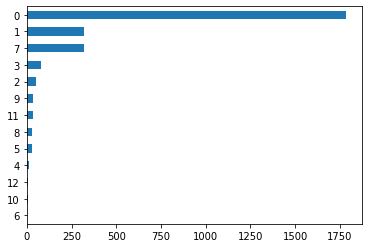

In [6]:
df['label'].value_counts().sort_values().plot(kind='barh')

In [7]:
df_timing = df.copy()
def change(x):
    if x == 0:
        return 0
    elif x % 2 == 1:
        return 1
    else:
        return 2

df_timing['label'] = df_timing['label'].apply(change)
def change(x):
    if x == 0:
        return 'Nothing'
    elif x == 1:
        return 'Day'
    else:
        return 'Night'
df_timing['label_name'] = df_timing['label'].apply(change)
df_timing[['label','label_name']].value_counts()

label  label_name
0      Nothing       1783
1      Day            808
2      Night          107
dtype: int64

In [8]:
label2id,id2label = dict(),dict()
for i in df_timing[['label','label_name']].value_counts().items():
    label2id[i[0][1]] = i[0][0]
    id2label[i[0][0]] = i[0][1]
id2label

{0: 'Nothing', 1: 'Day', 2: 'Night'}

In [33]:
# dataset = 
# for img_path in df_timing['video_path'].values:
#     img = DatasetDict

In [9]:
import random
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore') 

In [10]:
CFG = {# 10프레임 * 5초
    'IMG_SIZE':128,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':4,
    'SEED':41
}

In [11]:
from transformers import ViTFeatureExtractor,ViTForImageClassification

In [12]:
from PIL import Image

In [42]:

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list,label2id,id2label,model_name='google/vit-base-patch16-224-in21k'):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.model_name = model_name
        self.label2id = label2id
        self.id2label = id2label
        self.image_processor = ViTFeatureExtractor.from_pretrained(model_name)
        
    def __getitem__(self, index):
        img = self.get_img(self.img_path_list[index])
        inputs = self.image_processor(img, return_tensors="pt")
        if self.label_list is not None:
            label = self.label_list[index]
            inputs['label'] = label
            return inputs
        else:
            return inputs
        
    def __len__(self):
        return len(self.img_path_list)
    
    def get_img(self, path):
        # img = Image.open(path)
        img = cv2.imread(path)
        # img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
        # img = img / 255.
        
        return img

In [45]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

In [43]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [14]:
test_img = cv2.imread('./train_thumbnail/TRAIN_0000.jpg')
# cv2.imshow('image', test_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [35]:
test_img = Image.open('./train_thumbnail/TRAIN_0002.jpg')
feature_extracter = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
input = feature_extracter(images=test_img,return_tensors='pt')
outputs = model(**input).logits

outputs.argmax(-1).item()
# logits
# input


919

In [38]:
input

{'pixel_values': tensor([[[[ 0.8588,  0.8667,  0.8667,  ...,  0.4902,  0.5843,  0.5922],
          [ 0.8588,  0.8667,  0.8667,  ...,  0.4824,  0.5843,  0.5922],
          [ 0.8588,  0.8667,  0.8667,  ...,  0.4667,  0.5686,  0.5765],
          ...,
          [-0.2549, -0.2549, -0.2706,  ..., -0.5294, -0.5529, -0.5765],
          [-0.2549, -0.2549, -0.3020,  ..., -0.5137, -0.5137, -0.5686],
          [-0.2471, -0.2706, -0.2941,  ..., -0.5216, -0.5373, -0.6000]],

         [[ 0.9765,  0.9843,  0.9843,  ...,  0.6549,  0.7569,  0.7647],
          [ 0.9765,  0.9843,  0.9843,  ...,  0.6471,  0.7569,  0.7647],
          [ 0.9765,  0.9843,  0.9843,  ...,  0.6314,  0.7412,  0.7490],
          ...,
          [-0.1529, -0.1529, -0.1765,  ..., -0.4824, -0.4980, -0.5216],
          [-0.1529, -0.1529, -0.2078,  ..., -0.4667, -0.4588, -0.5137],
          [-0.1451, -0.1686, -0.2078,  ..., -0.4667, -0.4824, -0.5451]],

         [[ 0.9373,  0.9451,  0.9451,  ...,  0.6392,  0.7412,  0.7490],
          [ 0

In [36]:
print(input['pixel_values'].shape)

torch.Size([1, 3, 224, 224])


In [40]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

In [41]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['img'],
        return_tensors='pt'
    )
    # include the labels
    inputs['label'] = batch['label']
    return inputs

In [24]:
train, val, _, _ = train_test_split(df_timing, df_timing['label'], test_size=0.2, random_state=CFG['SEED'])

In [25]:
train_dataset = CustomDataset(train['video_path'].values, train['label'].values,label2id,id2label)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val['video_path'].values, val['label'].values,label2id,id2label)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [27]:

def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    # feature_extracter = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
    
    best_val_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for img, labels in tqdm(iter(train_loader)):
            # img = feature_extracter(img,return_tensors = 'pt')
            img = img.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            logits = model(**img).logits
            output = logits.argmax(-1).item()
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
    
    return best_model
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []
    
    with torch.no_grad():
        for img, labels in tqdm(iter(val_loader)):
            img = feature_extracter(img,return_tensors = 'pt')
            img = img.to(device)
            labels = labels.to(device)
            
            logits = model(**img).logits
            output = logits.argmax(-1).item()
            loss = criterion(output, labels)
            
            val_loss.append(loss.item())
            
            preds += logits.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()
        
        _val_loss = np.mean(val_loss)
    
    _val_score = f1_score(trues, preds, average='macro')
    return _val_loss, _val_score

In [28]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
model.eval()
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/540 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 4)

In [30]:
from datasets import load_dataset, load_metric

In [ ]:

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

batch_size = 32

training_args = TrainingArguments(output_dir="test_trainer", 
                                  remove_unused_columns=False,
                                  evaluation_strategy = "epoch",
                                  save_strategy = "epoch",
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=batch_size,
                                  gradient_accumulation_steps=4,
                                  per_device_eval_batch_size=batch_size,
                                  num_train_epochs=2,
                                  warmup_ratio=0.1,
                                  logging_steps=10,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy",
                                  )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)